In [ ]:
# Import required libraries
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image


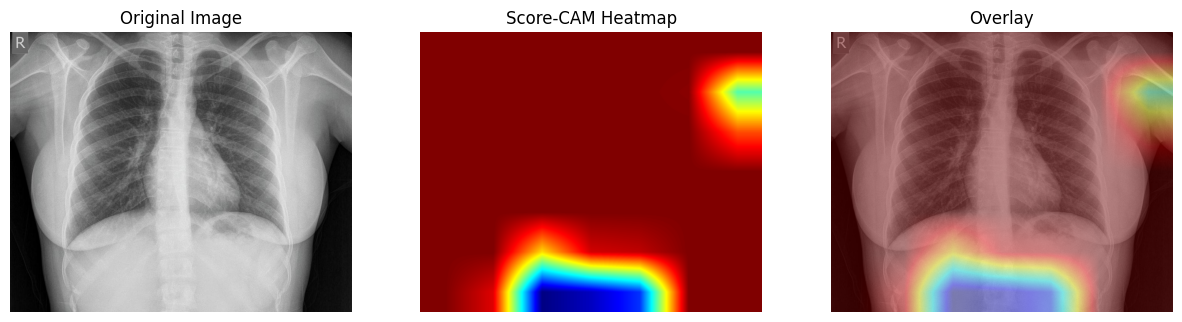

In [2]:


# Load pre-trained ResNet50 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()  # Set model to evaluation mode

# Global variable to store activations
activations = None

# Hook function to capture forward activations
def forward_hook(module, input, output):
    global activations
    activations = output  # Capture activation maps

# Register the hook on the last convolutional layer of ResNet50
target_layer = model.layer4[2].conv3
target_layer.register_forward_hook(forward_hook)

# Preprocess image function
def preprocess_image(img_path):
    """
    Loads and transforms an image to the format expected by ResNet:
      - Resizes to 224x224
      - Converts to tensor
      - Normalizes with ImageNet stats
    """
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0).to(device)  # Move to GPU/CPU

# Compute Score-CAM
def compute_score_cam(img_path, class_idx):
    """
    Implements Score-CAM:
      - Gets activation maps
      - Perturbs input by each activation map
      - Uses model's confidence score to weight each map
    """
    # Forward pass to capture activations
    img_tensor = preprocess_image(img_path)
    _ = model(img_tensor)  # Just run forward to set 'activations'

    # Convert activations to NumPy
    global activations
    activation_maps = activations.squeeze(0).detach().cpu().numpy()  # shape: (C, H, W)
    num_channels = activation_maps.shape[0]
    scores = []

    # For each activation map, create a perturbed image and measure class score
    for i in range(num_channels):
        # 1) Resize activation map to 224x224
        upsampled_map = cv2.resize(activation_maps[i], (224, 224))

        # Normalize the map between 0 and 1
        min_val, max_val = upsampled_map.min(), upsampled_map.max()
        if max_val - min_val > 0:
            upsampled_map = (upsampled_map - min_val) / (max_val - min_val)
        else:
            upsampled_map = np.zeros_like(upsampled_map)

        # 2) Multiply original image by the upsampled map
        perturbed_input = img_tensor.clone()
        mask_tensor = torch.tensor(upsampled_map, dtype=torch.float32, device=device).unsqueeze(0)  # FIXED: Removed extra dim
        for c in range(3):  # for each RGB channel
            perturbed_input[:, c, :, :] *= mask_tensor  # Now it correctly broadcasts

        # 3) Get model score for the chosen class
        with torch.no_grad():
            score = F.softmax(model(perturbed_input), dim=1)[0, class_idx].item()
        scores.append(score)

    # 4) Normalize scores between 0 and 1
    scores = np.array(scores)
    s_min, s_max = scores.min(), scores.max()
    if s_max - s_min > 0:
        scores = (scores - s_min) / (s_max - s_min)
    else:
        scores = np.zeros_like(scores)

    # 5) Combine activation maps weighted by scores
    score_cam_map = np.sum(activation_maps * scores[:, np.newaxis, np.newaxis], axis=0)
    score_cam_map = np.maximum(score_cam_map, 0)  # ReLU
    # Normalize final heatmap
    if score_cam_map.max() > 0:
        score_cam_map /= score_cam_map.max()

    return score_cam_map

# Overlay heatmap on original image
def overlay_heatmap(img_path, heatmap):
    """
    - Resizes heatmap to match original image
    - Applies a color map
    - Blends heatmap with the original image
    """
    # Read original image with OpenCV (BGR format)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    # Resize heatmap to match the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to 8-bit and apply color map
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Blend images (0.6 of original, 0.4 of heatmap)
    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)
    return img, heatmap_color, overlay

# Visualization for Colab
def display_results(img_path, heatmap, overlay):
    """
    Displays:
      1) Original Image
      2) Heatmap
      3) Overlay of heatmap on original
    in a single row using Matplotlib.
    """
    original = Image.open(img_path).convert('RGB')

    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Score-CAM Heatmap")
    plt.axis("off")

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()

# Example usage in Colab
img_path = "3-normal-healthy-chest-x-ray-photostock-israel.jpg"
class_idx = 243  # Example class from ImageNet (Boxer dog)

# Generate Score-CAM heatmap
heatmap = compute_score_cam(img_path, class_idx)

# Generate overlay
img_original, heatmap_img, overlay_img = overlay_heatmap(img_path, heatmap)

# Display results
display_results(img_path, heatmap_img, overlay_img)
